<a href="https://colab.research.google.com/github/frapasti/Embedded-Person-detection/blob/main/Yolo_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

* Import all the needed libraries for the notebook
* Load the Coco training dataset and the bboxes containig persons

In [1]:
!pip install natsort &> /dev/null
!pip install fiftyone --no-binary fiftyone,voxel51-eta &> /dev/null #No need to show the output of the installation...

import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

import os
from natsort import natsorted
import cv2
import imutils
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from math import trunc
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers.core import Dense, Dropout, Activation 
from keras.utils import np_utils
from keras.layers import LeakyReLU   
from keras.regularizers import l2  
from keras.models import Model                   

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

NumExpr defaulting to 2 threads.
Migrating database to v0.16.5


In [2]:
#DATASET containing persons
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["detections"],
    classes=["person"],
    only_matching = True,
    max_samples=10000,
)

 100% |██████|    1.9Gb/1.9Gb [2.5s elapsed, 0s remaining, 862.4Mb/s]       
Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'
 100% |██████████████| 10000/10000 [14.6m elapsed, 0s remaining, 10.9 images/s]      
Writing annotations for 10000 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'train'
 100% |█████████████| 10000/10000 [45.9s elapsed, 0s remaining, 225.0 samples/s]      
Dataset 'coco-2017-train-10000' created


In [3]:
f = open('/root/fiftyone/coco-2017/train/labels.json')
data = json.load(f)
annotations = data['annotations']
every_path = []
cols = 10
rows = 10000
bbox_size = 4
counters = [0] * rows
bboxes = [[] for i in range(rows)] 
items = 0
# Creation of the list of paths of images in the dataset and bboxes
# This elements are extracted from the json file downloaded from coco with the dataset
for entry in data['annotations']:
    class_id = entry['category_id']
    if (class_id == 1):
        img_id = entry['image_id']
        path = float(img_id)/pow(10,11)
        dec_path = format(path, '.11f')
        final_path = ''
        final_path = '/root/fiftyone/coco-2017/train/data/'+ dec_path.replace('.', '') + '.jpg'
        if(every_path.count(final_path) == 0):
          every_path.append(final_path)
          bboxes[items].append(entry['bbox'])
          items = items + 1
        else:
          index = every_path.index(final_path)
          if(counters[index] + 1 < 10):
            bboxes[index].append(entry['bbox'])
            counters[index] = counters[index] + 1

# Matain only images of size 640x480
f_every_path = []
f_bboxes = []
for i in range(0, len(every_path)):
  original_img = load_img(every_path[i])
  width, height = original_img.size
  if(width == 640 and height == 480):
    f_every_path.append(every_path[i])
    f_bboxes.append(bboxes[i])

assert(len(bboxes)==len(every_path))

In [4]:
#DATASET of non persons
dataset1 = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    only_matching = True,
    max_samples=5000,
)

class_name = "Person"

# Find samples that have a "Person"
pos_view = dataset1.filter_labels("ground_truth", F("label")==class_name)

# Find all samples without a positively labeled "Person"
neg_view = dataset1.exclude(pos_view)

# Tag any samples that have a person in the App with "remove"
session = fo.launch_app(view=neg_view)

Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'
 100% |████████████████| 5000/5000 [7.6m elapsed, 0s remaining, 10.9 images/s]      
Writing annotations to '/root/fiftyone/coco-2017/validation/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [38.0s elapsed, 0s remaining, 138.4 samples/s]      
Dataset 'coco-2017-validation-5000' created


In [5]:
# Find and remove all tagged samples from the DatasetView
neg_view = neg_view.match_tags("remove", bool=False)

neg_view.export(
    export_dir="/content/nonPerson1",
    dataset_type=fo.types.COCODetectionDataset,
)

# Mantain only images of size 640x480
non_persons = listdir_fullpath("/content/nonPerson1/data")
for i in range(0, len(non_persons)):
  original_img = load_img(non_persons[i])
  width, height = original_img.size
  if(width == 640 and height == 480):
    f_every_path.append(non_persons[i])
    f_bboxes.append([])

print("The notebook is valuating performances over " + str(len(f_every_path)) + " images of size 640x480 containing zero or more persons")

 100% |███████████████| 2307/2307 [15.1s elapsed, 0s remaining, 187.1 samples/s]      
The notebook is valuating performances over 2478 images of size 640x480 containing zero or more persons


# BATCH GENERATOR

This class generates batches of data from the list of bboxes and img_paths, in this way new batches are genereated every epoch and ram problems, derived from creating a single really big X and Y, are avoided.

The images and boxes have to be passed converted in a specific format in order for Yolo to work:

Each input image is resized to 448x448 format as required by Yolo for its input.

Then create the grid of cells that Yolo analyzes. The size of the grid is 7x7 meaning that each cell will have a size of 64x64.

For each bounding box, scale it down to 448x448 format then calculate its center, the center will be in the grid at which the bounding box is associated. Each grid cell has a bounding box associated with it (zero if no bounding box). The bounding box has this form [P, Ox, Oy, W, H]:

P = probability that there's a hand (always 1 since we are taking ground truth boxes)
Ox = X center of the bounding box w.r.t to that grid, each grid has coordinates defined by (0,0) and (1,1) being respectively the up-left and down-rigth corner of such grid
Oy = Y center with same reasoning as above
W = width of the bounding box w.r.t the grid size
H = height of the bounding box w.r.t. the grid size
So, as an example, a bounding box b = [208,208,104,104] will be associated to the cell at row = 3 and column = 3 and become b_new = [1 ,0.5 ,0.5 , 2, 2]



In [6]:
import numpy as np

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path_list, bboxes_list, batch_size=25, dim=(448,448,3),
                 divisions=7, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.path_list = path_list
        self.S = divisions
        self.bboxes_list = bboxes_list
        self.shuffle = shuffle
        self.on_epoch_end() #triggered at beginning and end of each epoch
        self.cell_size = dim[0]/divisions

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.path_list) / self.batch_size))

    def __getitem__(self, index):
      
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, Y = self.__data_generation(indexes)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.path_list))
        if self.shuffle == True: # For more robust data
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        Y = np.empty((self.batch_size,self.S,self.S,5))

        batch_num = 0
        # Generate data
        for i in indexes:
          original_img = load_img(self.path_list[i])
          width, height = original_img.size
          # load the image with the required size and calculate scale factors
          image = load_img(self.path_list[i], target_size=(448, 448))
          scale_w = 448 / width 
          scale_h = 448 / height
          image = img_to_array(image)
          # scale pixel values to [0, 1]
          image = image.astype('float32')
          image /= 255.0
          y_img = np.zeros((self.S,self.S,5))
          for box in self.bboxes_list[i]:
            xleft = int(box[0] * scale_w)
            yleft = int(box[1] * scale_h)
            b_width = int(box[2] * scale_w)
            b_height = int(box[3] * scale_h)
            
            ox = xleft + b_width/2
            oy = yleft + b_height/2
            # Calculate the coordinates of the cell in the grid that contains the center 
            grid_col = trunc(ox/self.cell_size)
            grid_row = trunc(oy/self.cell_size) 
            # Calculate the coordinates of the center of the bbox w.r.t the associated cell; (0,0) top left and (1,1) bottom right corners of the cell
            ox_cell = (ox - (grid_col)*self.cell_size)/self.cell_size
            oy_cell = (oy - (grid_row)*self.cell_size)/self.cell_size
            # Calculate the width and height of the bbox in terms of cell size, a bbox of width 448/S(cell size) will have grid_width = 1
            grid_width = b_width/self.cell_size
            grid_heigth = b_height/self.cell_size
            # Put the results into y; 1 represent the probability of the class
            y = [1,ox_cell,oy_cell,grid_width,grid_heigth]
            y_img[grid_row][grid_col] = y

          # Store sample
          X[batch_num,] = image

          # Store grid
          Y[batch_num,] = y_img
        
          batch_num += 1

        return X, Y

# LOSS FUNCTION
Definition of the loss function as the one used in the paper but simpler.

There are just 5 parameters for each cell [P, x, y, w, h] thus one bounding box per cell.

Hence penalize the sum square root of x,y,(w)^1/2,(h)^1/2 as in the paper but just for the cells that contain a box so those with P = y_true[0] = 1.

Then penalize the sum square root of P.

Then penalize the sum square root of P for the cells that do not contain boxes hence with P = y_true[0] = 0.

In [7]:
def custom_loss(y_true, y_pred):
  
  # y_true (Batch size, 7, 7, 5)
  # y_pred (Batch size, 7, 7, 5)

  mse = tf.keras.losses.MeanSquaredError(reduction = "sum") # Define the SUM squared error loss
  predictions = tf.reshape(y_pred,(-1,7,7,5)) # The predictions are a tensor, need some reshaping to manipulate it

  exists_box = tf.expand_dims(y_true[...,0], 3) # A box exists if the first entry of the cell is equal to 1 

  #------------#
  #| BOX LOSS |#
  #------------#

  pred_box = exists_box*predictions[...,1:5] #Calculate only loss for the cells that contain a box
  target_box = exists_box*y_true[...,1:5] #Target boxes

  epsilon = tf.fill(tf.shape(pred_box[..., 2:4]), 1e-6) #Needed to avoid divergence of square root derivatives in back propagation

  # width and height are penalyzed using the square root, however predictions can be negative so multiply by sign in order to obtain positive
  # and take absoulte value in the square root 
  wh_pred = tf.math.sign(pred_box[...,3:5]) * tf.math.sqrt(tf.math.abs(pred_box[...,3:5] + epsilon))
  wh_targ = tf.math.sqrt(target_box[...,3:5] + epsilon)

  # Get also centers
  xy_pred = pred_box[...,1:3]
  xy_true = target_box[...,1:3]

  # Concatenate the new xy and wh in order to calculate sum squared root
  final_pred_box = tf.concat([xy_pred,wh_pred], axis = 3)
  final_true_box = tf.concat([xy_true,wh_targ], axis = 3)
  box_loss = mse(tf.reshape(final_pred_box, (-1, tf.shape(final_pred_box)[-1])),tf.reshape(final_true_box, (-1, tf.shape(final_true_box)[-1])))
  

  #---------------#
  #| OBJECT LOSS |#
  #---------------#
  
  # Take only the first entry of each box corresponding to the probability that there's an object
  pred_obj = predictions[...,0:1]
  true_obj = y_true[...,0:1]

  #Calculate object loss as in the paper
  object_loss = mse(tf.reshape(exists_box*pred_obj, (-1, )), tf.reshape(exists_box*true_obj, (-1, )) )

  #------------------#
  #| NO OBJECT LOSS |#
  #------------------#

  # Calculate the loss for cells that don't have objects
  non_exists_box = 1 - exists_box
  no_object_loss = mse(tf.reshape(non_exists_box*pred_obj, (-1, )), tf.reshape(non_exists_box*true_obj, (-1, )))

  #--------------#
  #| FINAL LOSS |#
  #--------------#

  # Penalize more the box loss and less the no object loss   
  total_loss = 5*box_loss + object_loss + 0.5*no_object_loss
  
  return total_loss

# Skeleton architecture of custom Yolo

In [14]:
tf.keras.backend.clear_session()


yolo = Sequential()
lrelu = LeakyReLU(alpha=0.1)

yolo.add(tf.keras.layers.Conv2D(32, (7, 7), padding="same", strides = (1,1), input_shape=(448,448,3), kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", strides = (2,2), kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(64, (1, 1), padding="same", strides = (2,2), kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(128, (3, 3), padding="same", strides = (2,2), kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.BatchNormalization()) #Batch normalization needs to be executed before lrelu apparently 
yolo.add(LeakyReLU(alpha=0.1))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Reshape((2048,), input_shape=(4,4,128)))

yolo.add(Dense(245))

yolo.add(tf.keras.layers.Reshape((7,7,5), input_shape=(245,)))

yolo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 448, 32)      4736      
                                                                 
 batch_normalization (BatchN  (None, 448, 448, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 448, 448, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     2

# Training

In [ ]:
training_generator = DataGenerator(f_every_path, f_bboxes)

yolo.compile(loss=custom_loss, optimizer='adam', metrics = ['accuracy'])

history = yolo.fit(x = training_generator, epochs=10, verbose=1)

Epoch 1/10
35/99 [=========>....................] - ETA: 10:59 - loss: 19.6235 - accuracy: 0.0329

dict_keys(['loss', 'accuracy'])


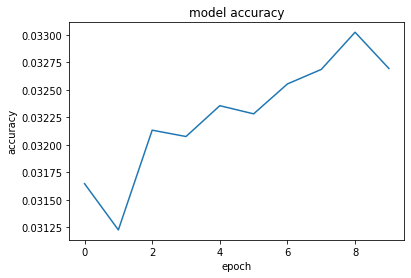

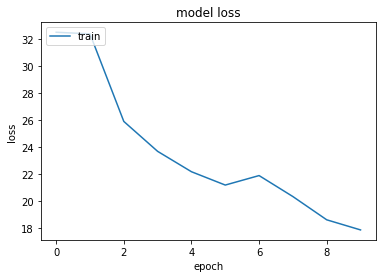

In [31]:
#Some plots for the training!

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [32]:
from scipy.io import savemat

mdic = {"loss": history.history['loss'] }
savemat("/content/Train_History/loss2.mat", mdic)

mdic = {"accuracy": history.history['accuracy'] }
savemat("/content/Train_History/accuracy2.mat", mdic)

In [33]:
yolo.save_weights('/content/yolo_person.h5')

# TESTING
Get some performance metrics for the model and visualize how it works in some test images

In [28]:
#Function to transform the output of the network in the correct format
def decode_net_out(out):
  # IN : out [7x7x5]
  # RETURNS : bboxes [list] of the best training boxes
  cell_size = 448/7
  bboxes = []
  confidences = []
  for i in range(0,7):
    for j in range(0,7):
      if out[i][j][0] > 0.5: #CONFIDENCE THRESHOLD (P of the cell)
        bbox = np.zeros((4))
        ox_cell = out[i][j][1]
        oy_cell = out[i][j][2]
        w_cell = out[i][j][3]
        h_cell = out[i][j][4]
        if(ox_cell != 0 and oy_cell !=0):
          ox = trunc(ox_cell*cell_size + cell_size*j)
          oy = trunc(oy_cell*cell_size + cell_size*i)
          w = w_cell*cell_size
          h = h_cell*cell_size
          lx = ox - w/2
          ly = oy - h/2
          bbox = [out[i][j][0],int(lx),int(ly),int(w),int(h)]
          bboxes.append(bbox)
  return bboxes

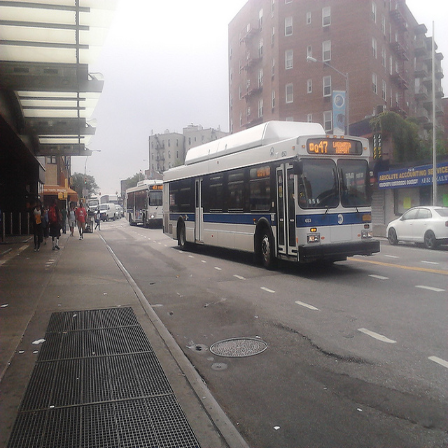

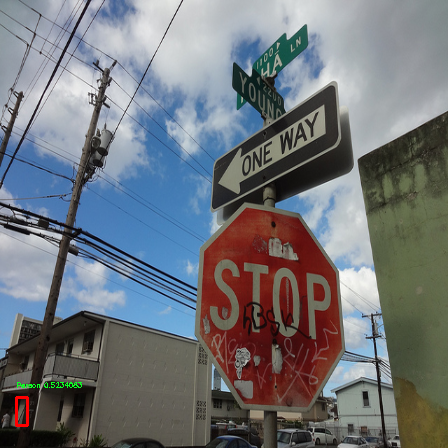

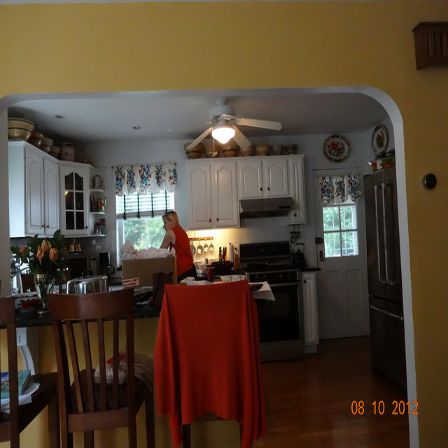

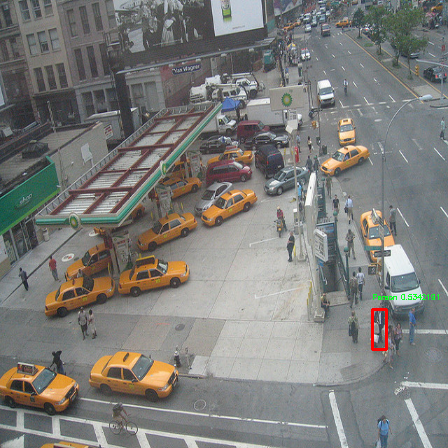

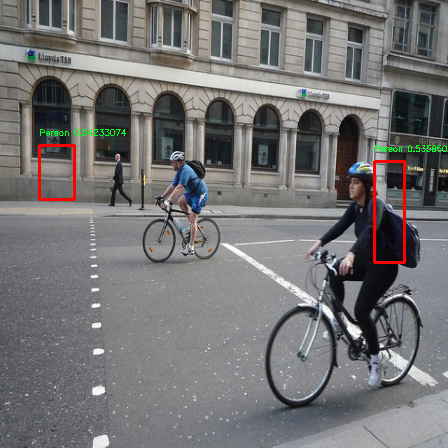

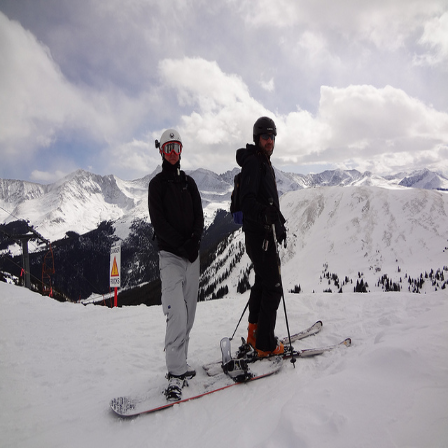

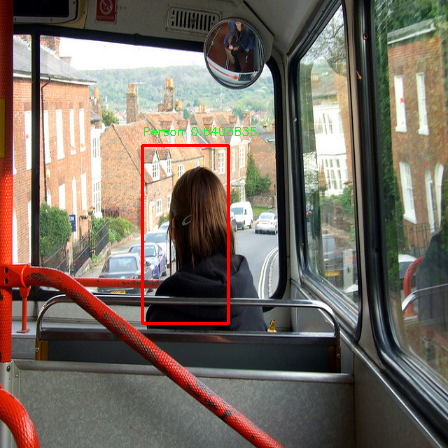

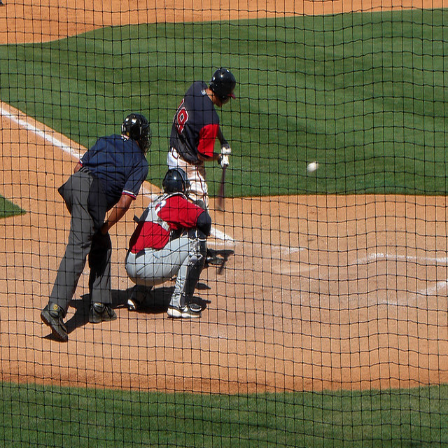

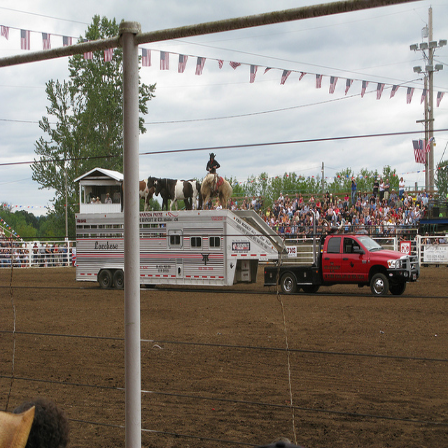

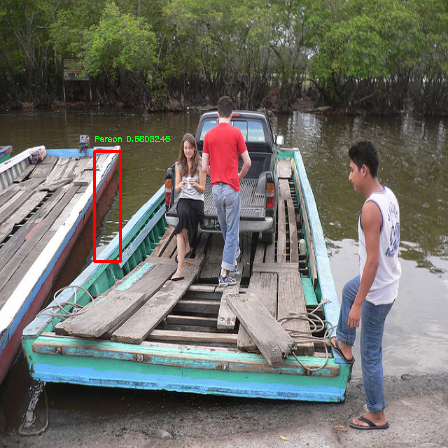

In [34]:
import random
for h in range(0, 10):
  i = random.randint(0,258)
  image = cv2.imread(f_every_path[i])
  image_show = cv2.resize(image,(448,448))
  loaded_img = load_img(f_every_path[i], target_size=(448, 448))
  scale_w = 448 / width 
  scale_h = 448 / height
  image = img_to_array(loaded_img)
  # scale pixel values to [0, 1]
  image = image.astype('float32')
  image /= 255.0
  in_net = np.expand_dims(image, axis=0) #Expand dimension because the network work with batches as input

  out_net = yolo.predict(in_net)
  out_bboxes = decode_net_out(out_net[0])

  # Drawing the regions in the Image
  for (P,x, y, w, h) in out_bboxes:
    cv2.rectangle(image_show, (x, y), 
                      (x + w, y + h), 
                       (0, 0, 255), 2)
    cv2.putText(image_show, 'Person ' + str(P), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, w/448 + 0.2, (36,255,12), 1)
  cv2_imshow(image_show)